# 見せかけの回帰とその対策

回帰分析を時系列データに適用した場合、関係ないはずなのに回帰が見られてしまうことがある。  

In [1]:
# install.packages("ggplot2")
# install.packages("prais")

In [2]:
# パッケージの読み込み
library(urca)
library(lmtest)
library(prais)
library(ggplot2)
library(ggfortify)
library(gridExtra)
library(repr)

# グラフのオプション
options(repr.plot.width=14, repr.plot.height=6)

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




## ホワイトノイズへの回帰分析

説明変数、目的変数にホワイトノイズを与えたとき(まったく関係ないデータ同士)を回帰分析にかけると、有意な係数は得られないはず。

In [3]:
R.version

               _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          4                           
minor          0.2                         
year           2020                        
month          06                          
day            22                          
svn rev        78730                       
language       R                           
version.string R version 4.0.2 (2020-06-22)
nickname       Taking Off Again            

In [4]:
# 1回のシミュレーションにおけるサンプルサイズ

n_sample <- 400

# 乱数の種

set.seed(1)

# シミュレーションデータの作成
y_wn <- rnorm(n = n_sample)

x_wn <- rnorm(n = n_sample)

In [5]:
# 回帰分析にかける
mod_ols_wn <- lm(y_wn ~ x_wn)

In [6]:
# 計算結果の確認
summary(mod_ols_wn)


Call:
lm(formula = y_wn ~ x_wn)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.91553 -0.60756 -0.06449  0.65797  2.64718 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  0.03993    0.04862   0.821    0.412
x_wn         0.02605    0.04500   0.579    0.563

Residual standard error: 0.9704 on 398 degrees of freedom
Multiple R-squared:  0.0008414,	Adjusted R-squared:  -0.001669 
F-statistic: 0.3352 on 1 and 398 DF,  p-value: 0.563


- Residuals: 残差の最大値・最小値など
- Coefficients: 推定された係数一覧
- p値は帰無仮説を「係数が0である」としたときのp値
- Multiple R-squared: 決定係数R^2
- Adjusted R-squared: 自由度調整済み決定係数

今回はp値が0.563なので帰無仮説は棄却され、有意な回帰係数は得られない、という結果になった。

## 単位根のあるデータ同士の回帰分析

単位根のあるデータで回帰分析を行うとどうなるか。  
ホワイトノイズの累積和として、ランダムウォーク過程をシミュレートする。  

cumsumは累積和をとる関数  
[1,2,3] ⇒ [1, 1+2, 1+2+3] ⇒ [1,3,6]

In [7]:
# 乱数種の指定
set.seed(1)

# ランダムウォークするデータ
y_rw <- cumsum(rnorm(n = n_sample))
x_rw <- cumsum(rnorm(n = n_sample))

In [8]:
# モデルの構築
mod_ols_rw <- lm(y_rw ~ x_rw)

# 結果の表示
summary(mod_ols_rw)


Call:
lm(formula = y_rw ~ x_rw)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.1820 -3.0629  0.4445  2.6711  8.3003 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.40661    0.29876   18.10   <2e-16 ***
x_rw        -0.28189    0.01738  -16.22   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.622 on 398 degrees of freedom
Multiple R-squared:  0.398,	Adjusted R-squared:  0.3965 
F-statistic: 263.1 on 1 and 398 DF,  p-value: < 2.2e-16


- p値がとんでもなく小さくなり、有意な回帰係数が得られてしまった。
- 決定係数も0.4近くとなっており、比較的大きな値になってしまった。

**まったく関係のないランダムウォーク系列を回帰分析にかけると、有意な回帰係数が得られかつ比較的高い説明力をゆうしたモデルが推定されてしまった。** ⇒ **見せかけの回帰**

データを図示して確認してみる。

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



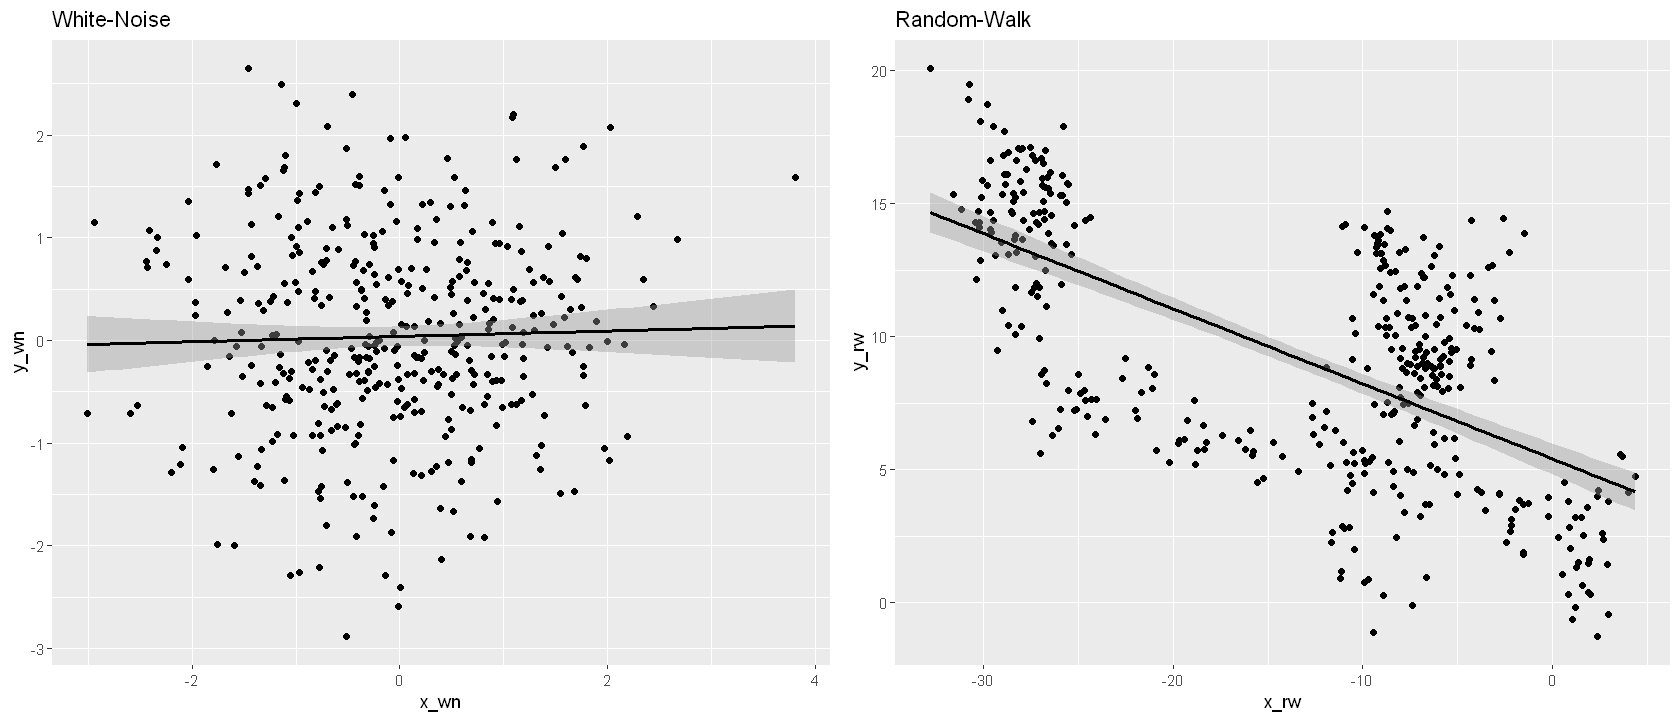

In [9]:
# データの整形
df_wn <- data.frame(x_wn = x_wn, y_wn = y_wn)
df_rw <- data.frame(x_rw = x_rw, y_rw = y_rw)

# ggplot2による図示
# ホワイトノイズ系列の回帰
p_wn <- ggplot(df_wn, aes(x=x_wn, y=y_wn)) + # 外枠
    geom_point() + # 散布図の追加
    geom_smooth(method="lm", colour=1) + # 回帰直線の追加
    ggtitle("White-Noise")  # グラフタイトル

# ランダムウォーク系列の回帰
p_rw <- ggplot(df_rw, aes(x=x_rw, y=y_rw)) + # 外枠
    geom_point() + # 散布図の追加
    geom_smooth(method="lm", colour=1) + # 回帰直線の追加
    ggtitle("Random-Walk")  # グラフタイトル

# グラフの表示
# gridExtraパッケージのgrid.arrange関数を使う
grid.arrange(p_wn, p_rw, ncol=2)

- ホワイトノイズ同士の散布図はデータがきれいにばらついている。
- ランダムウォーク系列同士の散布図は狭い箇所にデータが固まっていてホワイトノイズと明らかに異なる形状をいている。

## 定常AR過程への回帰分析

単位根過程ではなく、定常AR過程に下月シミュレーションデータを作成して、回帰分析を実行してみる。

In [10]:
# 乱数の指定
set.seed(2)

# 定常AR過程に従うデータ
y_ar <- arima.sim(
    n = n_sample,
    model = list(order = c(1,0,0), ar = c(0.8))
)

x_ar <- arima.sim(
    n = n_sample,
    model = list(order = c(1,0,0), ar = c(0.8))
)

- arima.sim: ARIMA過程に従うシミュレーションデータを作成する関数。
- ARはARIMA(1,0,0)で係数0.8

In [11]:
# 回帰分析の結果
mod_ols_ar <- lm(y_ar ~ x_ar)

# 結果の表示
summary(mod_ols_ar)


Call:
lm(formula = y_ar ~ x_ar)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.8320 -1.3404  0.0591  1.2246  4.6444 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.47574    0.08906   5.342 1.55e-07 ***
x_ar        -0.13483    0.04938  -2.731   0.0066 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.754 on 398 degrees of freedom
Multiple R-squared:  0.01839,	Adjusted R-squared:  0.01592 
F-statistic: 7.456 on 1 and 398 DF,  p-value: 0.006604


これもp値が0.05以下となっていまい、有意な回帰係数が得られてしまった。  
これも**見せかけの回帰** となった。

## 残差の自己相関と見せかけの回帰

- 見せかけの回帰が起こってしまう大きな理由が「残差に自己相関がある」ため。
- **「残差に自己相関があると、最小二乗推定量における有効性が失われることが知られている」**
    - 推定されたパラメータが「最も分散が小さい推定量である」という保証が得られなくなってしまう。

- 自己相関がある場合:
    - 係数の分散を過少推定してしまう。
    - 決定係数R^2が過大となる。
    - 係数のt検定が使えなくなる。

## Durbin-Watson検定(残差の自己相関の有無を調べる方法)

- 線形回帰分析の結果に対して自己相関の有無を検定する場合は、**Durbin-Watson(DW)検定** を使用することが多い。
- 残差の1次の自己相関が0であった場合は、DW統計量はおよそ2になる
- DWから2から離れているかを見れば、自己相関がどれくらいあるのかわかる

In [12]:
# DW統計量
resid_ols <- mod_ols_rw$residuals
dw <- sum(diff(resid_ols)^2) / sum((resid_ols)^2)
dw

[1] 0.08021259

DWが2よりかなり小さいので自己相関が残っていることがわかる。  

サンプルサイズと推定されたパラメタ数がわかれば、棄却点が計算できるため、DW統計量から残差の自己相関の検定を行うことができる。
DW検定の帰無仮説は**自己相関が0である**

In [13]:
# ホワイトノイズについてDW検定
dwtest(mod_ols_wn)

# ランダムウォークについてDW検定
dwtest(mod_ols_rw)

# AR(1)過程についてDW検定
dwtest(mod_ols_ar)


	Durbin-Watson test

data:  mod_ols_wn
DW = 2.0935, p-value = 0.8261
alternative hypothesis: true autocorrelation is greater than 0



	Durbin-Watson test

data:  mod_ols_rw
DW = 0.080213, p-value < 2.2e-16
alternative hypothesis: true autocorrelation is greater than 0



	Durbin-Watson test

data:  mod_ols_ar
DW = 0.3874, p-value < 2.2e-16
alternative hypothesis: true autocorrelation is greater than 0


確かにホワイトノイズは自己相関がみられないので2に近い値となった。  
ランダムウォーク、AR過程は自己相関がありそうなことがわかった。

## シミュレーションによる見せかけの回帰
見せかけの回帰が、どのくらいの頻度で発生するのんかをシミュレーションで確認する。  

種々の回帰分析のP値を取得して、p値が小さいものをカウントする。

In [14]:
# p値を取得するには
summary(mod_ols_wn)$coefficients

# これで取得できる
summary(mod_ols_wn)$coefficients["x_wn", "Pr(>|t|)"]

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.03993162,0.04862201,0.8212663,0.4119863
x_wn,0.02605077,0.04499733,0.5789403,0.5629569


[1] 0.5629569

In [15]:
# シミュレーションの回数
n_sim <- 200

# 1度のシミュレーションにおけるサンプルサイズ
n_sample <- 400

# p値を格納する変数
p_wn = numeric(n_sim)
p_rw = numeric(n_sim)

In [16]:
# シミュレーションの実行
set.seed(1)

for(i in 1:n_sim){
    # 自己相関のないシミュレーションデータ
    y_wn <- rnorm(n = n_sample)
    x_wn <- rnorm(n = n_sample)
    
    # 線形回帰分析の実行
    mod_wn <- lm(y_wn ~ x_wn)
    # p値を保尊
    p_wn[i] <- summary(mod_wn)$coefficients["x_wn", "Pr(>|t|)"]

    # ランダムウォークのシミュレーションデータ
    y_rw <- cumsum(rnorm(n = n_sample))
    x_rw <- cumsum(rnorm(n = n_sample))
    
    # 線形回帰分析の実行
    mod_rw <- lm(y_rw ~ x_rw)
    # p値を保尊
    p_rw[i] <- summary(mod_rw)$coefficients["x_rw", "Pr(>|t|)"]

}

# p値が0.05以下のものをカウント
# ホワイトノイズ
sum(p_wn < 0.05) / n_sim

# ランダムウォーク
sum(p_rw < 0.05) / n_sim

[1] 0.055

[1] 0.85

- ホワイトノイズ系列は0.055となった
    - 理論上は5%の割合で有意となるはずなので理論値に近い値となった。
- ランダムォーク系列は0.85となった
    - 85％もの割合で有意な回帰係数が得られてしまった。

ランダムォーク系列に対して回帰分析を実行すると、高い割合で見せかけの回帰が引き起こされてしまう。

## 見せかけの回帰を防ぐ方法

- 過去のデータをモデルに組込み、データの持つ自己相関を表現するモデルを作るというのが最も良い方法
    - GLS, ARIMAX, VAR, 状態空間モデル

- 単位根を持つデータであった場合は、差分系列へ回帰分析を実行する
- 差分をとる方法は簡単だが、問題もある。

## 単位根検定

urcaパッケージのur.df関数を使用してADF検定をためしてみる。

In [17]:
# ランダムウォークへのADF検定
# y
summary(ur.df(y_rw, type = "none"))
# x
summary(ur.df(x_rw, type = "none"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.69362 -0.76935 -0.01875  0.61984  3.10863 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
z.lag.1    -0.007932   0.008430  -0.941    0.347
z.diff.lag -0.037636   0.050540  -0.745    0.457

Residual standard error: 1 on 396 degrees of freedom
Multiple R-squared:  0.004097,	Adjusted R-squared:  -0.0009326 
F-statistic: 0.8146 on 2 and 396 DF,  p-value: 0.4436


Value of test-statistic is: -0.9409 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4968 -0.6984  0.0219  0.8117  3.0420 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
z.lag.1    -0.0008817  0.0030911  -0.285    0.776
z.diff.lag -0.0148436  0.0501355  -0.296    0.767

Residual standard error: 1.04 on 396 degrees of freedom
Multiple R-squared:  0.0004466,	Adjusted R-squared:  -0.004602 
F-statistic: 0.08847 on 2 and 396 DF,  p-value: 0.9153


Value of test-statistic is: -0.2852 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62


## 一般化最小二乗法

自己相関をもつデータに対しては普通の最小二乗法(Ordinary Least Squares: OLS)ではなく、  
**一般化最小二乗法(Generalized Least Squares: GLS)** を使う。  

**Pris-Winston法** を使って**実行可能(Feasible)一般化最小二乗法:FGLS** と呼ぶ。  
単回帰モデルをOLSで推定し、その残差を求めてみる。

In [18]:
# 定常AR(1)過程に従うデータをOLSでモデル化
mod_ols_ar <- lm(y_ar ~ x_ar)

# 残差
resid_ols_ar <- mod_ols_ar$residuals

In [19]:
# 残差に対して再度OLSを用いて残差の自己相関を表すρを求める
mod_resid <- lm(resid_ols_ar[-1] ~ resid_ols_ar[-n_sample] - 1)

ro <- as.numeric(mod_resid$coefficients)

ro

[1] 0.8078253

- resid_ols_ar[-1]: 1番めのデータを取り除いた残差
- resid_ols_ar[-n_sample]: 最後のデータを取り除いた残差
- [-1]を追加すると切片がない回帰モデルを構築する

In [20]:
# 初期時点のデータ
y_trans_1 <- sqrt(1 - ro^2)*y_ar[1]
x_trans_1 <- sqrt(1 - ro^2)*x_ar[1]
psi_trans_1 <- sqrt(1 - ro^2)

In [21]:
# 2 ~ 399時点のデータを変換
y_trans_2 <- y_ar[-1] - ro*y_ar[-n_sample]
x_trans_2 <- x_ar[-1] - ro*x_ar[-n_sample]
psi_trans_2 <- rep(1 - ro, n_sample-1)

In [22]:
# 両者をベクトルとして結合する
y_trans_all <- c(y_trans_1, y_trans_2)
x_trans_all <- c(x_trans_1, x_trans_2)
psi_trans_all <- c(psi_trans_1, psi_trans_2)

In [23]:
# OLS推定量を求める
# 切片はpsi
mod_gls_hand <- lm(y_trans_all ~ psi_trans_all + x_trans_all - 1)

# 結果
summary(mod_gls_hand)


Call:
lm(formula = y_trans_all ~ psi_trans_all + x_trans_all - 1)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.80161 -0.72467 -0.01121  0.72617  2.82948 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
psi_trans_all  0.46817    0.26604   1.760   0.0792 .
x_trans_all   -0.01720    0.05135  -0.335   0.7378  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.032 on 398 degrees of freedom
Multiple R-squared:  0.007859,	Adjusted R-squared:  0.002873 
F-statistic: 1.576 on 2 and 398 DF,  p-value: 0.208


変換後の傾きの係数のp値は0.7378となっており、有意な回帰係数は得られないという結果になった。

## パッケージを使ったGLS
praisパッケージのprais.winsten関数を使う。dataframe型しか受け付けないので変換する必要がある。

In [24]:
d <- data.frame(
    y_ar = y_ar,
    x_ar = x_ar
)

In [29]:
# Prais-Winsten法を実行する
mod_gls_PW <- prais_winsten(y_ar ~ x_ar, data=d, max_iter=1)
mod_gls_PW

Iteration 0: rho = 0
Iteration 1: rho = 0.8078


Estimation was stopped, because the maximum number of iterations was reached.




Call:
prais_winsten(formula = y_ar ~ x_ar, data = d, max_iter = 1)

Coefficients:
(Intercept)         x_ar  
     0.4682      -0.0172  

AR(1) coefficient rho: 0.8078


## 差分系列への回帰分析
単位根があるデータへの回帰分析
ランダムウォーク系列なら差分をとるとホワイトノイズになるので、見せかけの回帰は起こらないはず。

In [31]:
mod_lm_diff <- lm(diff(y_rw) ~ diff(x_rw))
summary(mod_lm_diff)


Call:
lm(formula = diff(y_rw) ~ diff(x_rw))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.63491 -0.73367  0.04338  0.65956  3.14882 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) -0.02864    0.05012  -0.571    0.568
diff(x_rw)  -0.01742    0.04818  -0.362    0.718

Residual standard error: 1.001 on 397 degrees of freedom
Multiple R-squared:  0.0003292,	Adjusted R-squared:  -0.002189 
F-statistic: 0.1307 on 1 and 397 DF,  p-value: 0.7179


p値が0.718なので見せかけの回帰を回避できていることがわかる。

## 共和分

$y_t$と$x_t$が各々単位根を持っているが、線形結合をすると単位根が無くる場合、$y_t$と$x_t$は共和分の関係にあると呼ぶ。

In [32]:
# 共和分関係をもつデータの特徴をシミュレーションで確かめる。
set.seed(10)

rw <- cumsum(rnorm(n = n_sample))  # ランダムウォーク(単位根をもつ)
x_co <- 0.6 * rw + rnorm(n = n_sample)  # 単位根をもつ
y_co <- 0.4 * rw + rnorm(n = n_sample)  # 単位根をもつ

# ADF検定をして単位根をもつことを確認する
summary(ur.df(y_co, type = "none"))
summary(ur.df(x_co, type = "none"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.0281 -0.8282 -0.0794  0.8101  3.4312 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
z.lag.1    -0.012165   0.009448  -1.288    0.199    
z.diff.lag -0.453423   0.044548 -10.178   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.236 on 396 degrees of freedom
Multiple R-squared:  0.2162,	Adjusted R-squared:  0.2122 
F-statistic: 54.62 on 2 and 396 DF,  p-value: < 2.2e-16


Value of test-statistic is: -1.2875 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.6304 -1.0182 -0.0304  0.8609  4.3365 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
z.lag.1    -0.007435   0.007294  -1.019    0.309    
z.diff.lag -0.418492   0.045650  -9.167   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.436 on 396 degrees of freedom
Multiple R-squared:  0.1803,	Adjusted R-squared:  0.1762 
F-statistic: 43.57 on 2 and 396 DF,  p-value: < 2.2e-16


Value of test-statistic is: -1.0194 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62


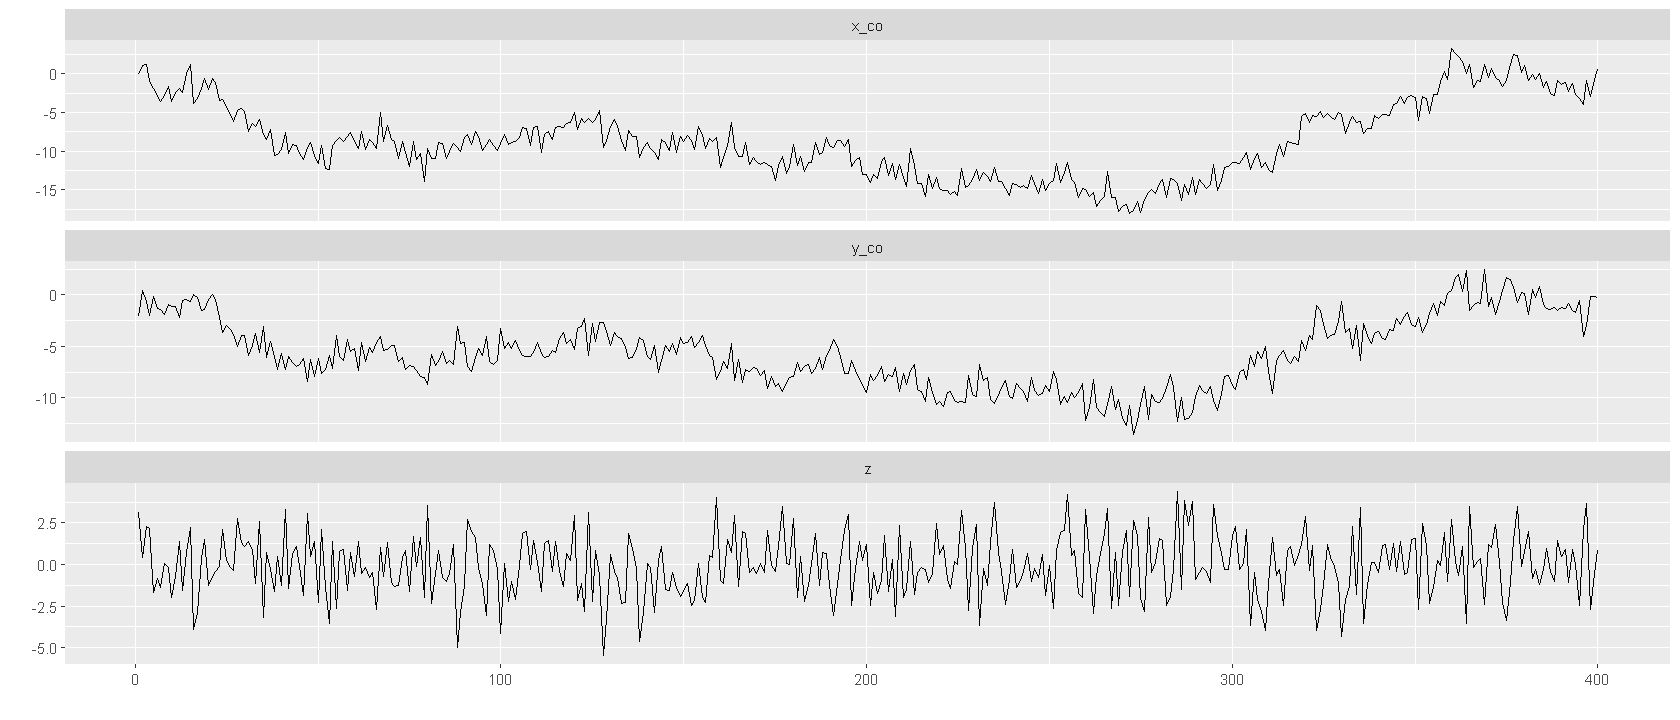

In [33]:
# 線形結合して図示してみる

# データをひとつにまとめる
df <- data.frame(
    y_co = y_co, 
    x_co = x_co,
    z = x_co - (0.6/0.4)*y_co
)

# ts型に変換
ts_df <- ts(df)

# 図示
autoplot(ts_df, facets = T)

単位根があったとしても、共和分関係にあれば、意味のある関係性を持つと考察できる。

## 共和分検定

二つの変数の間に共和分があるかどうかを調べるために共和分検定を行う。  
共和分検定には**Engle-Granger**の方法を用いる。  
この方法は2変数での共和分関係を調べることにしか使えないことに注意する。  

In [34]:
# データの整形
data_mat <- matrix(nrow = n_sample, ncol = 2)
data_mat[, 1] <- y_co
data_mat[, 2] <- x_co

# 共和分検定
summary(ca.po(data_mat, demean="none"))


######################################## 
# Phillips and Ouliaris Unit Root Test # 
######################################## 

Test of type Pu 
detrending of series none 


Call:
lm(formula = z[, 1] ~ z[, -1] - 1)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0870 -0.8575 -0.0049  0.7570  3.5471 

Coefficients:
        Estimate Std. Error t value Pr(>|t|)    
z[, -1] 0.655250   0.006071   107.9   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.199 on 399 degrees of freedom
Multiple R-squared:  0.9669,	Adjusted R-squared:  0.9668 
F-statistic: 1.165e+04 on 1 and 399 DF,  p-value: < 2.2e-16


Value of test-statistic is: 250.7453 

Critical values of Pu are:
                  10pct    5pct    1pct
critical values 20.3933 25.9711 38.3413


**Value of test-statistic is: 250.7453** に検定統計量が記されている。  
棄却点が25.9711なので「共和分関係がない」という帰無仮説は棄却された。共和分関係がある、ということ。

共和分関係にあるデータに対して差分系列への回帰分析を行うと、その関係は見えなくなってしまうので注意すること。

In [36]:
# 共和分のあるデータに、差分をとってから回帰
y_co_diff <- diff(y_co)
x_co_diff <- diff(x_co)

mod_lm_diff_cointegrate <- lm(y_co_diff ~ x_co_diff)
summary(mod_lm_diff_cointegrate)


Call:
lm(formula = y_co_diff ~ x_co_diff)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.0064 -0.9438 -0.0613  0.9665  3.7408 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) 0.004719   0.070014   0.067    0.946
x_co_diff   0.047463   0.044286   1.072    0.284

Residual standard error: 1.399 on 397 degrees of freedom
Multiple R-squared:  0.002885,	Adjusted R-squared:  0.0003732 
F-statistic: 1.149 on 1 and 397 DF,  p-value: 0.2845


回帰係数が有意にならなくなった。